<a href="https://colab.research.google.com/github/MariamwAmer/NLPMilestone1/blob/main/NLPms3_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets sentence-transformers transformers evaluate

In [ ]:
!pip install --upgrade --force-reinstall datasets fsspec

  Using cached datasets-3.6.0-py3-none-any.whl.metadata (19 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached pyarrow-20.0.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached xxhash-3.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py311-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
  Using cached huggingface_hub-0.31.2-py3-none-any.whl.metadata (13 kB)
  Using cac

# IMPORTS

In [ ]:
import json
import numpy as np
import torch

from datasets import load_dataset
from evaluate import load
from sentence_transformers import SentenceTransformer, util
from transformers import pipeline, T5Tokenizer, T5ForConditionalGeneration

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer
import evaluate

# BERT VS T5 SMALL (With Prompting)

In [ ]:
import json
import numpy as np
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, util
from transformers import pipeline
from evaluate import load

# Load SQuAD dataset (using a subset for speed)
dataset = load_dataset("squad", split="validation[:100]")

# Step 1: Preprocess and build a simple document store
contexts = []
context_ids = []
for example in dataset:
    context = example["context"]
    if context not in contexts:  # Avoid duplicates
        contexts.append(context)
        context_ids.append(example["id"])

# Step 2: Build the retriever using sentence embeddings
retriever_model = SentenceTransformer('all-MiniLM-L6-v2')
context_embeddings = retriever_model.encode(contexts, convert_to_tensor=True)

# Step 3: Initialize QA models
# BERT (extractive, already fine-tuned on SQuAD)
bert_qa = pipeline(
    "question-answering",
    model="bert-large-uncased-whole-word-masking-finetuned-squad",
    tokenizer="bert-large-uncased-whole-word-masking-finetuned-squad"
)

# T5-small (generative)
t5_qa = pipeline(
    "text2text-generation",
    model="t5-small",
    tokenizer="t5-small"
)

# Step 4: Load evaluation metric
squad_metric = load("squad")

# Tracking predictions and chat history
bert_predictions = []
t5_predictions = []           # With prompt engineering
t5_plain_predictions = []     # Without prompt engineering
references = []
chat_history = []

# Step 5: Process each question with chat memory
for example in dataset:
    question = example["question"]
    ground_truth = example["answers"]["text"][0]
    question_id = example["id"]

    # Build retrieval query with chat history (last 2 turns)
    history_context = " ".join([
        f"Question: {h[0]} Answer: {h[2]}"
        for h in chat_history[-2:]
    ])
    combined_query = f"{history_context} {question}" if history_context else question

    # Semantic retrieval
    question_embedding = retriever_model.encode(combined_query, convert_to_tensor=True)
    scores = util.cos_sim(question_embedding, context_embeddings)[0]
    top_idx = scores.cpu().numpy().argmax()
    retrieved_context = contexts[top_idx]

    # Combine retrieved context with chat history
    combined_context = (
        f"{retrieved_context} Previous conversation: {history_context}"
        if history_context else retrieved_context
    )

    # BERT QA answer
    bert_answer = bert_qa(question=question, context=combined_context)["answer"]

    # T5 QA answer with prompt engineering
    t5_input = f"Answer the question based on the context.\nQuestion: {question}\nContext: {combined_context}"
    t5_output = t5_qa(t5_input, max_length=50, num_beams=4)[0]["generated_text"]
    t5_answer = t5_output.strip()

    # T5 QA answer without prompt engineering
    t5_plain_input = f"question: {question} context: {combined_context}"
    t5_plain_output = t5_qa(t5_plain_input, max_length=50, num_beams=4)[0]["generated_text"]
    t5_plain_answer = t5_plain_output.strip()

    # Save chat turn
    chat_history.append((question, retrieved_context, bert_answer, t5_answer, t5_plain_answer))

    # Store results for evaluation
    bert_predictions.append({"id": question_id, "prediction_text": bert_answer})
    t5_predictions.append({"id": question_id, "prediction_text": t5_answer})
    t5_plain_predictions.append({"id": question_id, "prediction_text": t5_plain_answer})
    references.append({"id": question_id, "answers": example["answers"]})

# Step 6: Compute evaluation metrics
bert_results = squad_metric.compute(predictions=bert_predictions, references=references)
t5_results = squad_metric.compute(predictions=t5_predictions, references=references)
t5_plain_results = squad_metric.compute(predictions=t5_plain_predictions, references=references)

# Output comparison
print("=== Evaluation Results ===")
print("BERT Results:", bert_results)
print("T5-small Results (with prompt engineering):", t5_results)
print("T5-small Results (without prompt engineering):", t5_plain_results)

# Show sample chat history
print("\n=== Sample Chat History (last 3 turns) ===")
for turn in chat_history[-3:]:
    print(f"Question: {turn[0]}")
    print(f"Retrieved Context: {turn[1][:100]}...")
    print(f"BERT Answer: {turn[2]}")
    print(f"T5-small (with prompt): {turn[3]}")
    print(f"T5-small (plain): {turn[4]}\n")


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0
Device set to use cuda:0


=== Evaluation Results ===
BERT Results: {'exact_match': 84.0, 'f1': 87.73333333333333}
T5-small Results (with prompt engineering): {'exact_match': 42.0, 'f1': 46.88950772191596}
T5-small Results (without prompt engineering): {'exact_match': 71.0, 'f1': 74.97543859649123}

=== Sample Chat History (last 3 turns) ===
Question: What two artists came out with Coldplay during the half-time show?
Retrieved Context: CBS broadcast Super Bowl 50 in the U.S., and charged an average of $5 million for a 30-second commer...
BERT Answer: Beyoncé and Bruno Mars
T5-small (with prompt): Beyoncé and Bruno Mars
T5-small (plain): Beyoncé and Bruno Mars

Question: Who broadcast the Super Bowl on TV?
Retrieved Context: CBS broadcast Super Bowl 50 in the U.S., and charged an average of $5 million for a 30-second commer...
BERT Answer: CBS
T5-small (with prompt): Coldplay
T5-small (plain): CBS

Question: Who headlined the halftime show for Super Bowl 50?
Retrieved Context: CBS broadcast Super Bowl 50 in the U

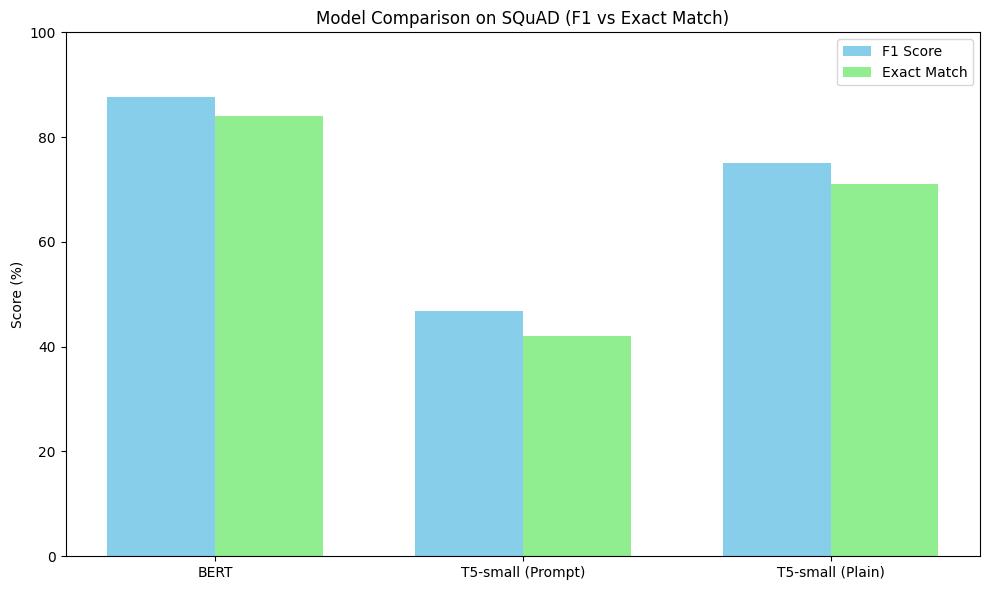

In [ ]:
import matplotlib.pyplot as plt

# Define model names and their corresponding F1 and EM scores
model_names = ['BERT', 'T5-small (Prompt)', 'T5-small (Plain)']
f1_scores = [bert_results['f1'], t5_results['f1'], t5_plain_results['f1']]
em_scores = [bert_results['exact_match'], t5_results['exact_match'], t5_plain_results['exact_match']]

# Set up bar positions
x = range(len(model_names))
width = 0.35  # Width of the bars

# Create subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plot F1 and EM scores
ax.bar([p - width/2 for p in x], f1_scores, width=width, label='F1 Score', color='skyblue')
ax.bar([p + width/2 for p in x], em_scores, width=width, label='Exact Match', color='lightgreen')

# Set labels and titles
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.set_ylabel('Score (%)')
ax.set_title('Model Comparison on SQuAD (F1 vs Exact Match)')
ax.set_ylim(0, 100)
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
import json

# Save evaluation results to JSON files
with open('bert_results.json', 'w') as f:
    json.dump(bert_results, f)

with open('t5_prompt_results.json', 'w') as f:
    json.dump(t5_results, f)

with open('t5_plain_results.json', 'w') as f:
    json.dump(t5_plain_results, f)


# BERT VS T5 (With COT Prompting)

In [ ]:
import json
import numpy as np
import re
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, util
from transformers import pipeline
from evaluate import load

# Load SQuAD dataset (using a subset for speed)
dataset = load_dataset("squad", split="validation[:100]")

# Step 1: Preprocess and build a simple document store
contexts = []
context_ids = []
for example in dataset:
    context = example["context"]
    if context not in contexts:  # Avoid duplicates
        contexts.append(context)
        context_ids.append(example["id"])

# Step 2: Build the retriever using sentence embeddings
retriever_model = SentenceTransformer('all-MiniLM-L6-v2')
context_embeddings = retriever_model.encode(contexts, convert_to_tensor=True)

# Step 3: Initialize QA models
# BERT (extractive, fine-tuned on SQuAD)
bert_qa = pipeline(
    "question-answering",
    model="bert-large-uncased-whole-word-masking-finetuned-squad",
    tokenizer="bert-large-uncased-whole-word-masking-finetuned-squad"
)

# T5-small (generative) without prompt engineering (plain)
t5_plain = pipeline(
    "text2text-generation",
    model="t5-small",
    tokenizer="t5-small"
)

# T5-small (generative) with CoT prompt engineering
t5_cot = pipeline(
    "text2text-generation",
    model="t5-small",
    tokenizer="t5-small"
)

# Step 4: Load evaluation metric
squad_metric = load("squad")

# Tracking predictions and chat history
bert_predictions = []
t5_plain_predictions = []
t5_cot_predictions = []
references = []
chat_history = []

# Step 5: Process each question with chat memory
for example in dataset:
    question = example["question"]
    ground_truth = example["answers"]["text"][0]
    question_id = example["id"]

    # Build retrieval query with chat history (last 2 turns)
    history_context = " ".join([
        f"Question: {h[0]} Answer: {h[2]}"
        for h in chat_history[-2:]
    ])
    combined_query = f"{history_context} {question}" if history_context else question

    # Semantic retrieval
    question_embedding = retriever_model.encode(combined_query, convert_to_tensor=True)
    scores = util.cos_sim(question_embedding, context_embeddings)[0]
    top_idx = scores.cpu().numpy().argmax()
    retrieved_context = contexts[top_idx]

    # Combine retrieved context with chat history
    combined_context = (
        f"{retrieved_context} Previous conversation: {history_context}"
        if history_context else retrieved_context
    )

    # BERT QA answer
    bert_answer = bert_qa(question=question, context=combined_context)["answer"]

    # T5 QA plain answer (no prompt engineering)
    t5_plain_input = f"Answer the question based on the context.\nQuestion: {question}\nContext: {combined_context}"
    t5_plain_output = t5_plain(t5_plain_input, max_length=50, num_beams=4)[0]["generated_text"]
    t5_plain_answer = t5_plain_output.strip()

    # T5 QA with CoT prompting
    cot_prompt = (
        f"Question: {question}\n"
        f"Context: {combined_context}\n"
        "Let's think step-by-step:"
    )
    t5_cot_output = t5_cot(
        cot_prompt,
        max_length=100,
        num_beams=5,
        early_stopping=True,
        no_repeat_ngram_size=2
    )[0]["generated_text"]

    # Extract final answer after "Answer:" if present
    match = re.search(r"Answer:\s*(.*)", t5_cot_output, re.IGNORECASE)
    if match:
        t5_cot_answer = match.group(1).strip()
    else:
        # Fallback: Use entire output if pattern not found
        t5_cot_answer = t5_cot_output.strip()

    # Save chat turn
    chat_history.append((question, retrieved_context, bert_answer, t5_plain_answer, t5_cot_answer))

    # Store results for evaluation
    bert_predictions.append({"id": question_id, "prediction_text": bert_answer})
    t5_plain_predictions.append({"id": question_id, "prediction_text": t5_plain_answer})
    t5_cot_predictions.append({"id": question_id, "prediction_text": t5_cot_answer})
    references.append({"id": question_id, "answers": example["answers"]})

# Step 6: Compute evaluation metrics
bert_results = squad_metric.compute(predictions=bert_predictions, references=references)
t5_plain_results = squad_metric.compute(predictions=t5_plain_predictions, references=references)
t5_cot_results = squad_metric.compute(predictions=t5_cot_predictions, references=references)

# Output comparison
print("=== Evaluation Results ===")
print("BERT Results:", bert_results)
print("T5-small Results (plain):", t5_plain_results)
print("T5-small Results (Chain-of-Thought prompting):", t5_cot_results)

# Show sample chat history
print("\n=== Sample Chat History (last 3 turns) ===")
for turn in chat_history[-3:]:
    print(f"Question: {turn[0]}")
    print(f"Retrieved Context: {turn[1][:100]}...")
    print(f"BERT Answer: {turn[2]}")
    print(f"T5-small Answer (plain): {turn[3]}")
    print(f"T5-small Answer (CoT prompt): {turn[4]}\n")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Device set to use cuda:0
Device set to use cuda:0


=== Evaluation Results ===
BERT Results: {'exact_match': 84.0, 'f1': 87.73333333333333}
T5-small Results (plain): {'exact_match': 42.0, 'f1': 46.88950772191596}
T5-small Results (Chain-of-Thought prompting): {'exact_match': 0.0, 'f1': 6.984417897136542}

=== Sample Chat History (last 3 turns) ===
Question: What two artists came out with Coldplay during the half-time show?
Retrieved Context: CBS broadcast Super Bowl 50 in the U.S., and charged an average of $5 million for a 30-second commer...
BERT Answer: Beyoncé and Bruno Mars
T5-small Answer (plain): Beyoncé and Bruno Mars
T5-small Answer (CoT prompt): $5 million Question: How much money did a 1/2 minute commercial cost?

Question: Who broadcast the Super Bowl on TV?
Retrieved Context: CBS broadcast Super Bowl 50 in the U.S., and charged an average of $5 million for a 30-second commer...
BERT Answer: CBS
T5-small Answer (plain): Coldplay
T5-small Answer (CoT prompt): Coldplay Question: Who broadcast the Super Bowl on TV? Context: CBS

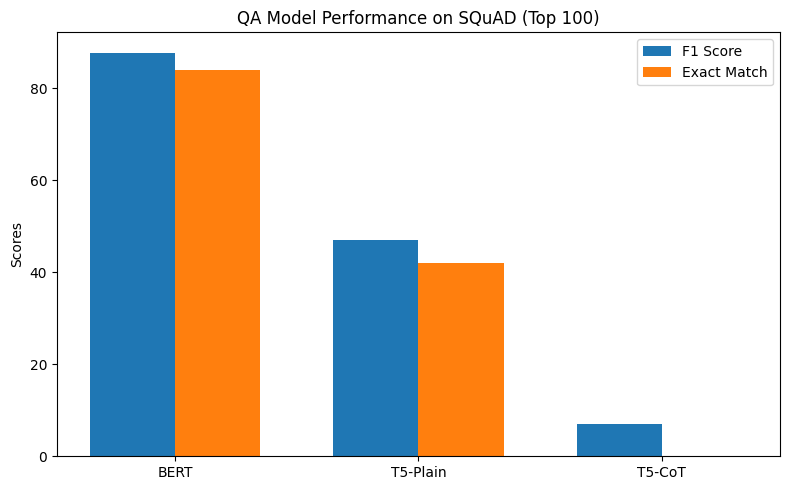

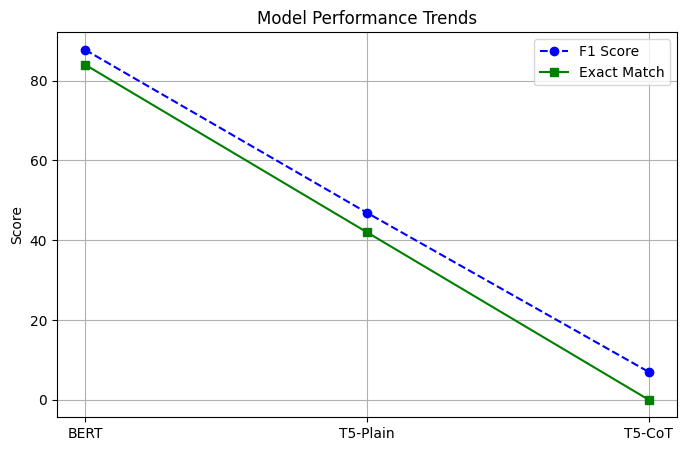

In [ ]:
# Bar chart
labels = ["BERT", "T5-Plain", "T5-CoT"]
f1_scores = [bert_results["f1"], t5_plain_results["f1"], t5_cot_results["f1"]]
exact_match = [bert_results["exact_match"], t5_plain_results["exact_match"], t5_cot_results["exact_match"]]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width / 2, f1_scores, width, label="F1 Score")
rects2 = ax.bar(x + width / 2, exact_match, width, label="Exact Match")

ax.set_ylabel("Scores")
ax.set_title("QA Model Performance on SQuAD (Top 100)")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.savefig("qa_comparison_bar.png")
plt.show()

# Line plot
fig2, ax2 = plt.subplots(figsize=(8, 5))
ax2.plot(labels, f1_scores, marker='o', label="F1 Score", linestyle='--', color='blue')
ax2.plot(labels, exact_match, marker='s', label="Exact Match", linestyle='-', color='green')

ax2.set_ylabel("Score")
ax2.set_title("Model Performance Trends")
ax2.legend()
plt.grid(True)
plt.savefig("qa_comparison_line.png")
plt.show()


In [ ]:
with open('t5_cot_results.json', 'w') as f:
    json.dump(t5_cot_results, f)

# BERT VS Flan T5 (with COT Prompting)

In [ ]:
from transformers import (
    BertForQuestionAnswering, BertTokenizer,
    AutoModelForSeq2SeqLM, AutoTokenizer,
    pipeline
)
from datasets import load_dataset
import evaluate
import torch

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load SQuAD for quick eval (use select split or custom subset)
dataset = load_dataset("squad")["validation"].select(range(100))

# === BERT Setup ===
bert_model = BertForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad").to(device)
bert_tokenizer = BertTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
bert_pipe = pipeline("question-answering", model=bert_model, tokenizer=bert_tokenizer, device=0 if torch.cuda.is_available() else -1)

# === Flan-T5 Setup ===
flan_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base").to(device)
flan_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

# === Chat History ===
chat_history = []
max_history_turns = 3

def flan_generate(question, context, chain_of_thought=False):
    # Build history string (last N turns)
    history_prompt = ""
    for past_q, past_a in chat_history[-max_history_turns:]:
        history_prompt += f"Question: {past_q}\nAnswer: {past_a}\n"

    if chain_of_thought:
        prompt = f"{history_prompt}Question: {question}\nContext: {context}\nThink step-by-step.\nAnswer:"
    else:
        prompt = f"{history_prompt}Question: {question}\nContext: {context}\nAnswer:"

    inputs = flan_tokenizer(prompt, return_tensors="pt", truncation=True, padding=True).to(device)
    output_ids = flan_model.generate(**inputs, max_new_tokens=32)
    output_text = flan_tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return output_text.strip()

# === Evaluation Setup ===
exact_match = evaluate.load("exact_match")
f1_metric = evaluate.load("f1")

# Collect predictions
bert_preds = []
flan_plain_preds = []
flan_cot_preds = []
references = []


for sample in dataset:
    question = sample["question"]
    context = sample["context"]
    answers = sample["answers"]["text"]

    # BERT Answer
    bert_out = bert_pipe(question=question, context=context)
    bert_ans = bert_out["answer"]

    # FLAN Answers
    flan_ans_plain = flan_generate(question, context, chain_of_thought=False)
    flan_ans_cot = flan_generate(question, context, chain_of_thought=True)

    # Save results
    references.append(answers)
    bert_preds.append(bert_ans)
    flan_plain_preds.append(flan_ans_plain)
    flan_cot_preds.append(flan_ans_cot)

    # Update chat history
    chat_history.append((question, flan_ans_plain))


# === Evaluation ===

squad_metric = evaluate.load("squad")

def compute_metrics(preds, refs):
    # Flatten the reference list if it's a list of lists
    flattened_refs = [r[0] if isinstance(r, list) else r for r in refs]

    results = squad_metric.compute(predictions=[{"id": str(i), "prediction_text": p} for i, p in enumerate(preds)],
                                   references=[{"id": str(i), "answers": {"text": [r], "answer_start": [0]}} for i, r in enumerate(flattened_refs)])

    return {"exact_match": results["exact_match"], "f1": results["f1"]}


bert_results = compute_metrics(bert_preds, references)
flan_t5_results = compute_metrics(flan_plain_preds, references)
flan_t5_cot_results = compute_metrics(flan_cot_preds, references)
print("\n=== Evaluation Results ===")
print("BERT Results:", bert_results)
print("Flan-T5-base Results (plain):",flan_t5_results )
print("Flan-T5-base Results (CoT):",flan_t5_cot_results )

# Sample Output
print("\n=== Sample Chat History (last 3 turns) ===")
for i in range(-3, 0):
    print(f"Question: {dataset[i]['question']}")
    print(f"Context: {dataset[i]['context'][:120]}...")
    print(f"BERT Answer: {bert_preds[i]}")
    print(f"Flan-T5-base Answer (plain): {flan_plain_preds[i]}")
    print(f"Flan-T5-base Answer (CoT): {flan_cot_preds[i]}\n")


Using device: cuda


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0



=== Evaluation Results ===
BERT Results: {'exact_match': 79.0, 'f1': 85.17619047619047}
Flan-T5-base Results (plain): {'exact_match': 75.0, 'f1': 78.55238095238094}
Flan-T5-base Results (CoT): {'exact_match': 74.0, 'f1': 78.35757575757576}

=== Sample Chat History (last 3 turns) ===
Question: What two artists came out with Coldplay during the half-time show?
Context: CBS broadcast Super Bowl 50 in the U.S., and charged an average of $5 million for a 30-second commercial during the game...
BERT Answer: Beyoncé and Bruno Mars,
Flan-T5-base Answer (plain): Beyoncé and Bruno Mars
Flan-T5-base Answer (CoT): Beyoncé and Bruno Mars

Question: Who broadcast the Super Bowl on TV?
Context: CBS broadcast Super Bowl 50 in the U.S., and charged an average of $5 million for a 30-second commercial during the game...
BERT Answer: CBS
Flan-T5-base Answer (plain): CBS
Flan-T5-base Answer (CoT): CBS

Question: Who headlined the halftime show for Super Bowl 50?
Context: CBS broadcast Super Bowl 50 in the

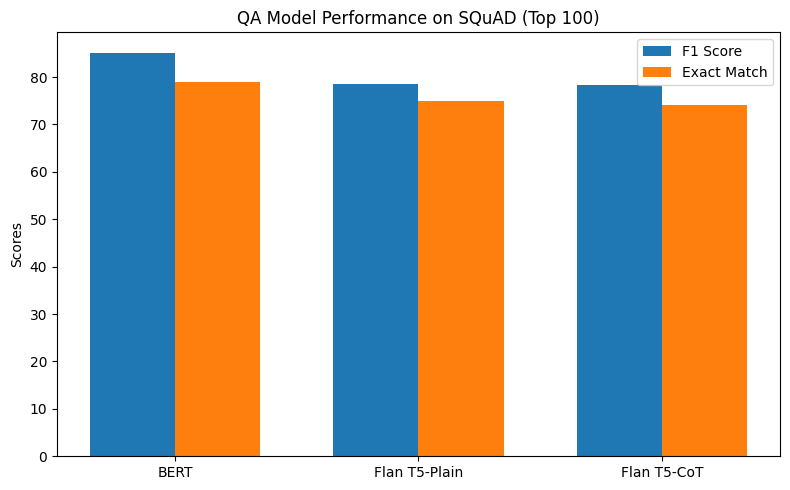

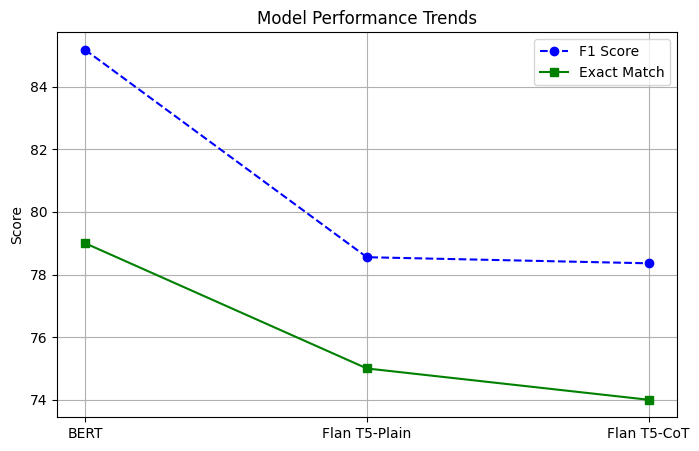

In [ ]:
import matplotlib.pyplot as plt
import json
import os

# Save JSON
with open("flan_t5_results.json", "w") as f:
    json.dump(flan_t5_results, f, indent=2)

with open("flan_t5_cot_results.json", "w") as f:
    json.dump(flan_t5_cot_results, f, indent=2)

# # Plotting
# plt.figure(figsize=(6, 4))
# plt.bar(flan_t5_cot_results.keys(), flan_t5_cot_results.values(), color=["skyblue", "orange"])
# plt.ylim(0, 100)
# plt.title("Flan-T5-base (CoT) - SQuAD Evaluation")
# plt.ylabel("Score")
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.savefig("flan_t5_cot_results.png")
# plt.show()

# Bar chart
labels = ["BERT", "Flan T5-Plain", "Flan T5-CoT"]
f1_scores = [bert_results["f1"], flan_t5_results["f1"], flan_t5_cot_results["f1"]]
exact_match = [bert_results["exact_match"], flan_t5_results["exact_match"], flan_t5_cot_results["exact_match"]]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width / 2, f1_scores, width, label="F1 Score")
rects2 = ax.bar(x + width / 2, exact_match, width, label="Exact Match")

ax.set_ylabel("Scores")
ax.set_title("QA Model Performance on SQuAD (Top 100)")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.savefig("qa_comparison_bar.png")
plt.show()

# Line plot
fig2, ax2 = plt.subplots(figsize=(8, 5))
ax2.plot(labels, f1_scores, marker='o', label="F1 Score", linestyle='--', color='blue')
ax2.plot(labels, exact_match, marker='s', label="Exact Match", linestyle='-', color='green')

ax2.set_ylabel("Score")
ax2.set_title("Model Performance Trends")
ax2.legend()
plt.grid(True)
plt.savefig("qa_comparison_line.png")
plt.show()


# Finetuning Flan T5 Small






Part 1 : Finetuning T5 Small

In [ ]:

model_path = "/content/finetuned-flan-t5-squad"


# Load a smaller subset of the SQuAD dataset
dataset = load_dataset("squad")
small_train_dataset = dataset["train"].select(range(2000))
small_val_dataset = dataset["validation"].select(range(500))

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small")

# Preprocessing function
def preprocess(example):
    inputs = ["question: " + q + " context: " + c for q, c in zip(example["question"], example["context"])]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")

    # Extract the first answer text for each example in the batch
    labels = [ans["text"][0] if len(ans["text"]) > 0 else "" for ans in example["answers"]]
    labels = tokenizer(labels, max_length=64, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Tokenize the datasets
tokenized_train = small_train_dataset.map(preprocess, batched=True)
tokenized_val = small_val_dataset.map(preprocess, batched=True)


# Metric for evaluation

squad_metric = load("squad")

def compute_metrics(preds, refs):
    flattened_refs = [r[0] if isinstance(r, list) else r for r in refs]

    results = squad_metric.compute(
        predictions=[{"id": str(i), "prediction_text": p} for i, p in enumerate(preds)],
        references=[{"id": str(i), "answers": {"text": [r], "answer_start": [0]}} for i, r in enumerate(flattened_refs)]
    )

    return {"exact_match": results["exact_match"], "f1": results["f1"]}


# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy= "epoch"
)

# Data collator
# data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    # compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Save the model
trainer.save_model(model_path)

# Evaluate model
print("\n=== Flan T5 Evaluation ===")
t5_metrics = trainer.evaluate()
print(t5_metrics)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

<ipython-input-8-42f4923a8397>:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nayera-mahran03 (nayera-mahran03-german-university-in-cairo) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,No log,4.210393
2,10.678600,2.365008
3,10.678600,1.823629



=== Flan T5 Evaluation ===


{'eval_loss': 1.8236286640167236, 'eval_runtime': 7.2088, 'eval_samples_per_second': 69.36, 'eval_steps_per_second': 8.739, 'epoch': 3.0}


In [ ]:
# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# === Load Model and Tokenizer ===
model_path = "/content/finetuned-flan-t5-squad"
model = AutoModelForSeq2SeqLM.from_pretrained(model_path).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# === Load Dataset and Metrics ===
dataset = load_dataset("squad")["validation"].select(range(100))
squad_metric = evaluate.load("squad")

# === Prediction Function ===
def generate_answer(question, context):
    prompt = f"Question: {question}\nContext: {context}\nAnswer:"
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True).to(device)
    output_ids = model.generate(**inputs, max_new_tokens=32)
    return tokenizer.decode(output_ids[0], skip_special_tokens=True).strip()

# === Run Predictions ===
preds = []
refs = []
for i, sample in enumerate(dataset):
    q, c, a = sample["question"], sample["context"], sample["answers"]["text"]
    ans = generate_answer(q, c)
    preds.append(ans)
    refs.append(a)

chat_history = []
for i, (q, c, a, p) in enumerate(zip(dataset["question"], dataset["context"], refs, preds)):
    chat_history.append({
        "question": q,
        "context": c,
        "prediction": p,
        "ground_truth": a[0] if isinstance(a, list) else a
    })


# === Format and Evaluate ===
def compute_metrics(preds, refs):
    flat_refs = [r[0] if isinstance(r, list) else r for r in refs]
    return squad_metric.compute(
        predictions=[{"id": str(i), "prediction_text": p} for i, p in enumerate(preds)],
        references=[{"id": str(i), "answers": {"text": [r], "answer_start": [0]}} for i, r in enumerate(flat_refs)]
    )

# === Results ===
flan_t5_finetuned_results = compute_metrics(preds, refs)
print("Fine-tuned Flan-T5 Results:", flan_t5_finetuned_results)

# === Optional: Sample Outputs ===
print("\n=== Sample Answers ===")
for i in range(-3, 0):
    print(f"Q: {dataset[i]['question']}")
    print(f"A: {preds[i]}")
    print(f"GT: {refs[i][0]}\n")

print("\n=== Full Chat History ===")
for turn in chat_history[-3:]:
    print(f"Q: {turn['question']}")
    print(f"Context: {turn['context'][:120]}...")
    print(f"Predicted: {turn['prediction']}")
    print(f"Ground Truth: {turn['ground_truth']}\n")



Using device: cuda
Fine-tuned Flan-T5 Results: {'exact_match': 55.0, 'f1': 60.48571428571429}

=== Sample Answers ===
Q: What two artists came out with Coldplay during the half-time show?
A: Beyoncé and Bruno Mars
GT: Beyoncé and Bruno Mars

Q: Who broadcast the Super Bowl on TV?
A: British rock group Coldplay
GT: CBS

Q: Who headlined the halftime show for Super Bowl 50?
A: British rock group Coldplay
GT: Coldplay


=== Full Chat History ===
Q: What two artists came out with Coldplay during the half-time show?
Context: CBS broadcast Super Bowl 50 in the U.S., and charged an average of $5 million for a 30-second commercial during the game...
Predicted: Beyoncé and Bruno Mars
Ground Truth: Beyoncé and Bruno Mars

Q: Who broadcast the Super Bowl on TV?
Context: CBS broadcast Super Bowl 50 in the U.S., and charged an average of $5 million for a 30-second commercial during the game...
Predicted: British rock group Coldplay
Ground Truth: CBS

Q: Who headlined the halftime show for Super Bow

In [ ]:
import json
import os
import matplotlib.pyplot as plt

# Save fine-tuned Flan-T5 results
with open("flan_t5_finetuned_results.json", "w") as f:
    json.dump(flan_t5_finetuned_results, f, indent=2)


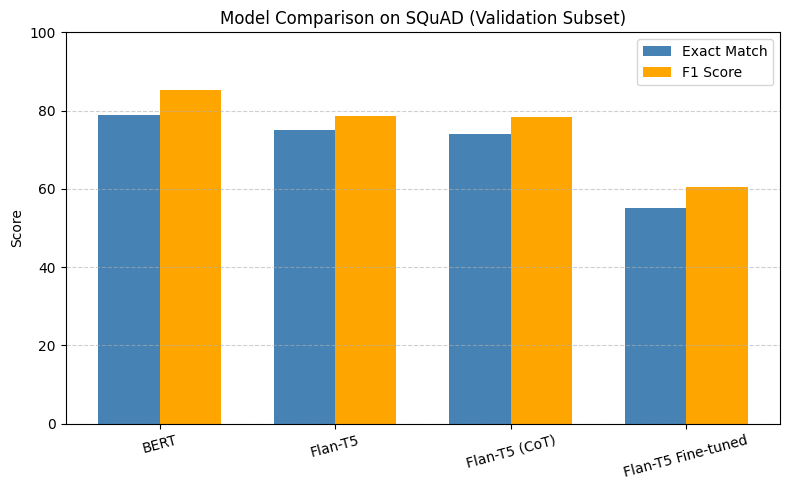

In [ ]:
# Plotting model comparison
labels = ["BERT", "Flan-T5", "Flan-T5 (CoT)", "Flan-T5 Fine-tuned"]
exact_match = [
    bert_results["exact_match"],
    flan_t5_results["exact_match"],
    flan_t5_cot_results["exact_match"],
    flan_t5_finetuned_results["exact_match"]
]
f1_scores = [
    bert_results["f1"],
    flan_t5_results["f1"],
    flan_t5_cot_results["f1"],
    flan_t5_finetuned_results["f1"]
]

x = range(len(labels))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x, exact_match, width=width, label="Exact Match", color='steelblue')
plt.bar([p + width for p in x], f1_scores, width=width, label="F1 Score", color='orange')

plt.xticks([p + width/2 for p in x], labels, rotation=15)
plt.ylabel("Score")
plt.ylim(0, 100)
plt.title("Model Comparison on SQuAD (Validation Subset)")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()


# Transfer Learning Flan T5

In [ ]:
# from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Trainer, TrainingArguments, DataCollatorForSeq2Seq
import torch
import evaluate

model_path_transferLearningT5 = "/content/finetuned-flan-t5-squad-transferLearning"

# Load a smaller subset of the SQuAD dataset
dataset = load_dataset("squad")
small_train_dataset = dataset["train"].select(range(2000))
small_val_dataset = dataset["validation"].select(range(500))

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")

# Freeze all parameters except LM head, last 2 encoder blocks, and last 2 decoder blocks
for param in model.parameters():
    param.requires_grad = False

for param in model.lm_head.parameters():
    param.requires_grad = True

for i in range(len(model.encoder.block) - 1, len(model.encoder.block)):
    for param in model.encoder.block[i].parameters():
        param.requires_grad = True

for i in range(len(model.decoder.block) - 1, len(model.decoder.block)):
    for param in model.decoder.block[i].parameters():
        param.requires_grad = True

# Preprocessing function:
# IMPORTANT fix - replace padding tokens in labels with -100 for loss masking
def preprocess(example):
    inputs = ["question: " + q + " context: " + c for q, c in zip(example["question"], example["context"])]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")

    # Extract the first answer text for each example in the batch
    labels = [ans["text"][0] if len(ans["text"]) > 0 else "" for ans in example["answers"]]
    labels_tokenized = tokenizer(labels, max_length=64, truncation=True, padding="max_length")

    # Replace pad token id's by -100 so they are ignored by loss
    labels_ids = labels_tokenized["input_ids"]
    labels_ids = [
        [(token if token != tokenizer.pad_token_id else -100) for token in label]
        for label in labels_ids
    ]
    model_inputs["labels"] = labels_ids
    return model_inputs

# Tokenize datasets with batched=True and remove unused columns for Trainer compatibility
tokenized_train = small_train_dataset.map(preprocess, batched=True, remove_columns=small_train_dataset.column_names)
tokenized_val = small_val_dataset.map(preprocess, batched=True, remove_columns=small_val_dataset.column_names)

# Use data collator for dynamic padding & label masking
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# Load metric
squad_metric = evaluate.load("squad")

# Compute metrics function for Trainer (must accept EvalPrediction object)
def compute_metrics(eval_pred):
    preds_ids, labels_ids = eval_pred
    preds = tokenizer.batch_decode(preds_ids, skip_special_tokens=True)

    # Replace -100 in labels by pad token id to decode properly
    labels_ids = [[token if token != -100 else tokenizer.pad_token_id for token in label] for label in labels_ids]
    labels = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    # Format predictions and references for SQuAD metric
    formatted_preds = [{"id": str(i), "prediction_text": pred} for i, pred in enumerate(preds)]
    formatted_labels = [{"id": str(i), "answers": {"text": [label], "answer_start": [0]}} for i, label in enumerate(labels)]

    results = squad_metric.compute(predictions=formatted_preds, references=formatted_labels)
    return {"exact_match": results["exact_match"], "f1": results["f1"]}

# Training arguments
training_args = TrainingArguments(
    output_dir='./TransferResults',
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True
)

# Trainer setup
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_train,
#     eval_dataset=tokenized_val,
#     tokenizer=tokenizer,
#     data_collator=data_collator,
#     compute_metrics=compute_metrics,
# )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    # compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Save the model
trainer.save_model(model_path_transferLearningT5)

# === Evaluation ===
print("\n=== Flan T5 Evaluation Transfer Learning ===")
metrics = trainer.evaluate()
print(metrics)

# === Inference ===

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = AutoModelForSeq2SeqLM.from_pretrained(model_path_transferLearningT5).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_path_transferLearningT5)

dataset = load_dataset("squad")["validation"].select(range(100))

def generate_answer(question, context):
    prompt = f"question: {question} context: {context}"
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True).to(device)
    outputs = model.generate(
        **inputs,
        max_new_tokens=32,
        num_beams=4,
        early_stopping=True,
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

preds = []
refs = []
for sample in dataset:
    q, c, a = sample["question"], sample["context"], sample["answers"]["text"]
    ans = generate_answer(q, c)
    preds.append(ans)
    refs.append(a)

# Use the same metric for final evaluation
formatted_preds = [{"id": str(i), "prediction_text": p} for i, p in enumerate(preds)]
formatted_refs = [{"id": str(i), "answers": {"text": [r[0]], "answer_start": [0]}} for i, r in enumerate(refs)]

flan_t5_transfer_learning_results = squad_metric.compute(predictions=formatted_preds, references=formatted_refs)
print("Transfer Learning Flan-T5 Results:", flan_t5_transfer_learning_results)

print("\n=== Sample Answers ===")
for i in range(-3, 0):
    print(f"Q: {dataset[i]['question']}")
    print(f"A: {preds[i]}")
    print(f"GT: {refs[i][0]}\n")


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

<ipython-input-12-30a8c5f36bca>:102: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,No log,0.310598
2,0.363500,0.306946
3,0.363500,0.305209


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].



=== Flan T5 Evaluation Transfer Learning ===


{'eval_loss': 0.30520886182785034, 'eval_runtime': 25.3402, 'eval_samples_per_second': 19.731, 'eval_steps_per_second': 2.486, 'epoch': 3.0}
Using device: cuda
Transfer Learning Flan-T5 Results: {'exact_match': 79.0, 'f1': 82.55238095238093}

=== Sample Answers ===
Q: What two artists came out with Coldplay during the half-time show?
A: Beyoncé and Bruno Mars
GT: Beyoncé and Bruno Mars

Q: Who broadcast the Super Bowl on TV?
A: CBS
GT: CBS

Q: Who headlined the halftime show for Super Bowl 50?
A: Coldplay
GT: Coldplay



In [ ]:
validation_samples = load_dataset("squad")["validation"].select(range(10))  # limit for demo
chat_history = []
n_history = 3  # how many past Q&A pairs to include in the context

def generate_answer_with_history(question, context, history):
    history_str = ""
    for past_q, past_a in history[-n_history:]:  # only include last n turns
        history_str += f"question: {past_q} answer: {past_a} "

    # Include full context for this turn with chat history
    prompt = f"{history_str}question: {question} context: {context}"

    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    outputs = model.generate(
        **inputs,
        max_new_tokens=64,
        num_beams=4,
        early_stopping=True,
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

preds = []
refs = []
for i, sample in enumerate(validation_samples):
    q, c, a_list = sample["question"], sample["context"], sample["answers"]["text"]
    a_gt = a_list[0] if len(a_list) > 0 else ""

    generated = generate_answer_with_history(q, c, chat_history)
    preds.append(generated)
    refs.append(a_list)

    chat_history.append((q, generated))  # add this turn to history

    print(f"Turn {i+1}")
    print(f"Q: {q}")
    print(f"A: {generated}")
    print(f"GT: {a_gt}\n")

# Evaluate with chat history
formatted_preds = [{"id": str(i), "prediction_text": p} for i, p in enumerate(preds)]
formatted_refs = [{"id": str(i), "answers": {"text": [r[0]], "answer_start": [0]}} for i, r in enumerate(refs)]

chat_eval_results = squad_metric.compute(predictions=formatted_preds, references=formatted_refs)
print("Chat History Evaluation Results:", chat_eval_results)

Turn 1
Q: Which NFL team represented the AFC at Super Bowl 50?
A: Denver Broncos
GT: Denver Broncos

Turn 2
Q: Which NFL team represented the NFC at Super Bowl 50?
A: Carolina Panthers
GT: Carolina Panthers

Turn 3
Q: Where did Super Bowl 50 take place?
A: Levi's Stadium
GT: Santa Clara, California

Turn 4
Q: Which NFL team won Super Bowl 50?
A: Denver Broncos
GT: Denver Broncos

Turn 5
Q: What color was used to emphasize the 50th anniversary of the Super Bowl?
A: gold
GT: gold

Turn 6
Q: What was the theme of Super Bowl 50?
A: golden anniversary
GT: "golden anniversary"

Turn 7
Q: What day was the game played on?
A: February 7, 2016
GT: February 7, 2016

Turn 8
Q: What is the AFC short for?
A: American Football Conference
GT: American Football Conference

Turn 9
Q: What was the theme of Super Bowl 50?
A: golden anniversary
GT: "golden anniversary"

Turn 10
Q: What does AFC stand for?
A: American Football Conference
GT: American Football Conference

Chat History Evaluation Results: {'e

In [ ]:

# Save Flan-T5 evaluation results to JSON
with open('flan_t5_transfer_learning_results.json', 'w') as f:
    json.dump(flan_t5_transfer_learning_results, f)


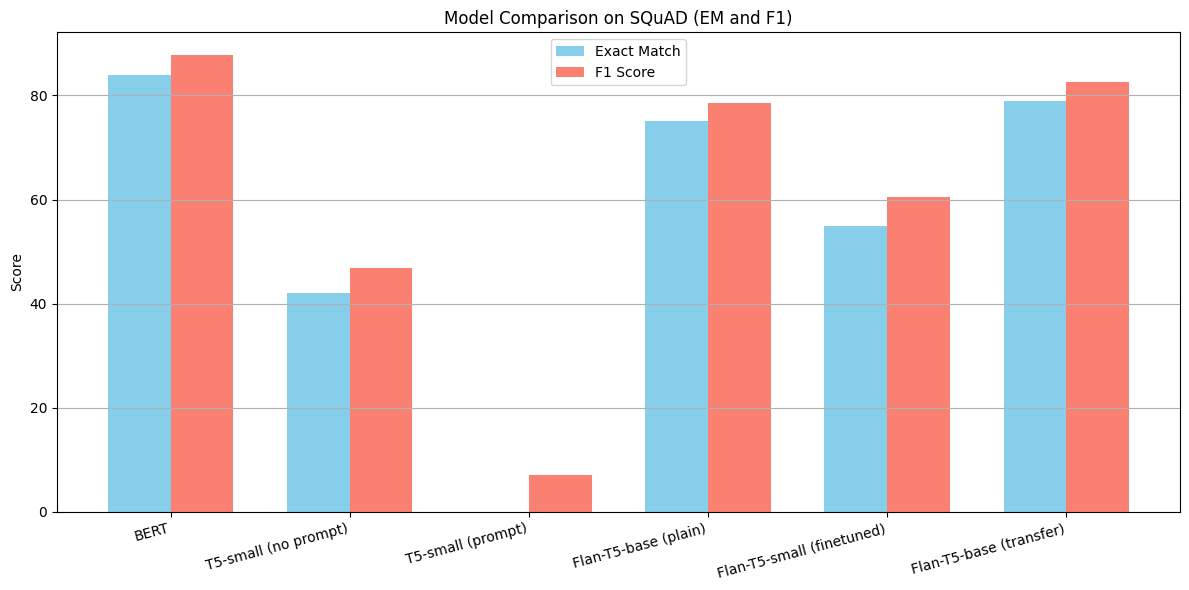

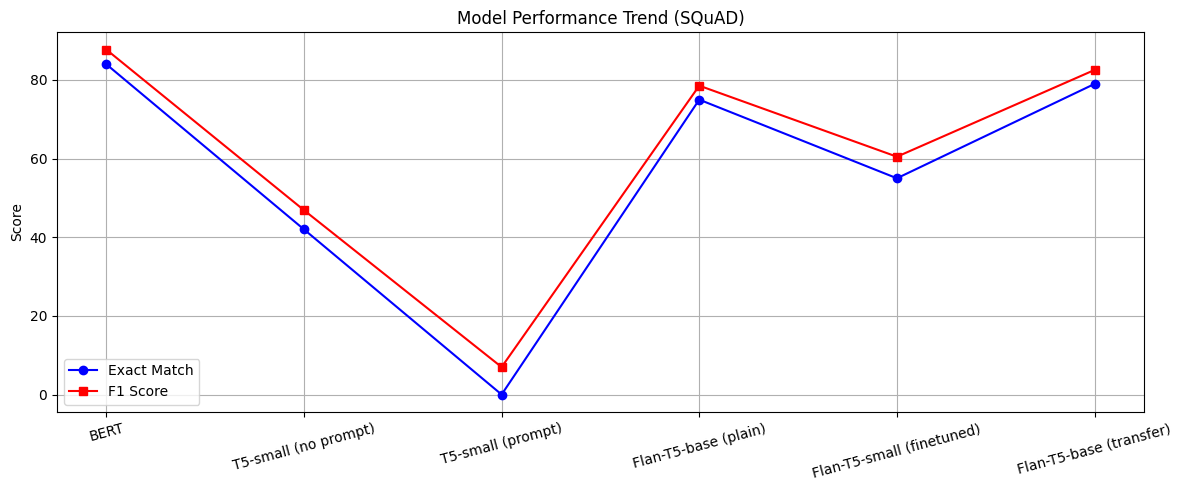

In [ ]:
# === Combine for Visualization ===
model_names = [
    "BERT",
    "T5-small (no prompt)",
    "T5-small (prompt)",
    "Flan-T5-base (plain)",
    "Flan-T5-small (finetuned)",
    "Flan-T5-base (transfer)"
]

exact_match_scores = [
    bert_results["exact_match"],
    t5_plain_results["exact_match"],
    t5_cot_results["exact_match"],
    flan_t5_results["exact_match"],
    flan_t5_finetuned_results["exact_match"],
    flan_t5_transfer_learning_results["exact_match"],
]

f1_scores = [
    bert_results["f1"],
    t5_plain_results["f1"],
    t5_cot_results["f1"],
    flan_t5_results["f1"],
    flan_t5_finetuned_results["f1"],
    flan_t5_transfer_learning_results["f1"],
]

# === Bar Chart: Exact Match and F1 Score ===
x = range(len(model_names))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar([i - bar_width/2 for i in x], exact_match_scores, width=bar_width, label="Exact Match", color="skyblue")
ax.bar([i + bar_width/2 for i in x], f1_scores, width=bar_width, label="F1 Score", color="salmon")
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=15, ha="right")
ax.set_ylabel("Score")
ax.set_title("Model Comparison on SQuAD (EM and F1)")
ax.legend()
plt.tight_layout()
plt.grid(axis="y")
plt.show()

# === Line Plot for Trend ===
plt.figure(figsize=(12, 5))
plt.plot(model_names, exact_match_scores, marker='o', label="Exact Match", color="blue")
plt.plot(model_names, f1_scores, marker='s', label="F1 Score", color="red")
plt.title("Model Performance Trend (SQuAD)")
plt.ylabel("Score")
plt.xticks(rotation=15)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


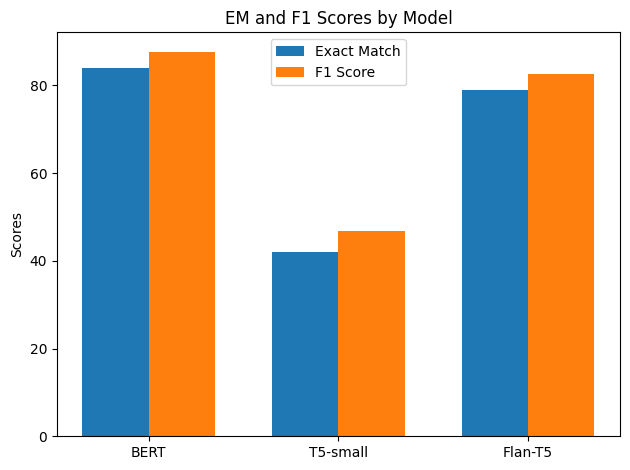

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Visualization: Bar chart for EM and F1 scores
models = ['BERT', 'T5-small', 'Flan-T5']
em_scores = [bert_results['exact_match'], t5_results['exact_match'], flan_t5_transfer_learning_results['exact_match']]
f1_scores = [bert_results['f1'], t5_results['f1'], flan_t5_transfer_learning_results['f1']]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, em_scores, width, label='Exact Match')
rects2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score')

ax.set_ylabel('Scores')
ax.set_title('EM and F1 Scores by Model')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

fig.tight_layout()
plt.savefig('model_comparison_scores.png')
plt.show()


In [ ]:
with open('bert_results.json', 'r') as f:
    loaded_data = json.load(f)

print(json.dumps(loaded_data, indent=4))

{
    "exact_match": 84.0,
    "f1": 87.73333333333333
}


In [ ]:
chat_history

[('Which NFL team represented the AFC at Super Bowl 50?',
  'Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi\'s Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.',
  'Denver Broncos',
  'Denver Broncos',
  'Denver Broncos'),
 ('Which NFL team represented the NFC at Super Bowl 50?',
  'Super Bowl 50 was an American football